In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_DIR = Path("..") / "Data"
PROCESSED_DIR = Path("..") / "data" / "processed"

PRICE_SCALE = 10_000.0
LEVELS = 10
ASK_DUMMY = 9_999_999_999
BID_DUMMY = -9_999_999_999

MSG_PATH = RAW_DIR / "GOOG_2012-06-21_34200000_57600000_message_10.csv"
OB_PATH  = RAW_DIR / "GOOG_2012-06-21_34200000_57600000_orderbook_10.csv"

PARQUET_PATH = PROCESSED_DIR / "goog_2012-06-21.parquet"
PICKLE_PATH  = PROCESSED_DIR / "goog_2012-06-21.pkl"


def load_df_standalone(levels: int = LEVELS) -> pd.DataFrame:
    """
    Standalone loader for this notebook:
    - if processed parquet/pkl exists -> load it
    - else -> read raw CSVs (message + orderbook), replace dummy prices, set time index
    """
    if PARQUET_PATH.exists():
        return pd.read_parquet(PARQUET_PATH)
    if PICKLE_PATH.exists():
        return pd.read_pickle(PICKLE_PATH)

    msg_cols = ["time", "type", "order_id", "size", "price", "direction"]
    msg = pd.read_csv(MSG_PATH, header=None, names=msg_cols)

    ob_cols = []
    for lvl in range(1, levels + 1):
        ob_cols += [f"ask_p{lvl}", f"ask_s{lvl}", f"bid_p{lvl}", f"bid_s{lvl}"]
    ob = pd.read_csv(OB_PATH, header=None, names=ob_cols, usecols=list(range(4 * levels)))

    assert len(msg) == len(ob), f"Row mismatch: msg={len(msg)} vs ob={len(ob)}"

    df = pd.concat([msg, ob], axis=1).sort_values("time", kind="mergesort")
    df = df.set_index("time", drop=False)

    # Dummy prices -> NaN (price columns only)
    ask_price_cols = [f"ask_p{i}" for i in range(1, levels + 1)]
    bid_price_cols = [f"bid_p{i}" for i in range(1, levels + 1)]
    df[ask_price_cols] = df[ask_price_cols].replace(ASK_DUMMY, np.nan)
    df[bid_price_cols] = df[bid_price_cols].replace(BID_DUMMY, np.nan)

    return df


df = load_df_standalone()
df.head()



,time,type,order_id,size,price,direction,ask_p1,ask_s1,bid_p1,bid_s1,...,bid_p9,bid_s9,ask_p10,ask_s10,bid_p10,bid_s10,ask_p1_d,bid_p1_d,spread,mid
time,,,,,,,,,,,,,,,,,,,,,
34200.015105,34200.015105,4,15818974,4,5794000,1,5802300.0,100,5794000.0,496,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.059902,34200.059902,4,15818974,300,5794000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795100,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5794900,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815


In [ ]:
#Core L1 microstructure features (USD)
valid_top = df["ask_p1"].notna() & df["bid_p1"].notna()

df["mid_d"] = np.nan
df["spread_d"] = np.nan
df.loc[valid_top, "mid_d"] = (df.loc[valid_top, "ask_p1"] + df.loc[valid_top, "bid_p1"]) / (2 * PRICE_SCALE)
df.loc[valid_top, "spread_d"] = (df.loc[valid_top, "ask_p1"] - df.loc[valid_top, "bid_p1"]) / PRICE_SCALE

den = (df["bid_s1"] + df["ask_s1"]).replace(0, np.nan)

df["micro_d"] = np.nan
df["imbalance_l1"] = np.nan
df.loc[valid_top, "micro_d"] = (
    (df.loc[valid_top, "ask_p1"] * df.loc[valid_top, "bid_s1"] + df.loc[valid_top, "bid_p1"] * df.loc[valid_top, "ask_s1"])
    / den.loc[valid_top]
) / PRICE_SCALE
df.loc[valid_top, "imbalance_l1"] = (df.loc[valid_top, "bid_s1"] - df.loc[valid_top, "ask_s1"]) / den.loc[valid_top]

# Sanity checks
neg_share = (df.loc[valid_top, "spread_d"] < 0).mean()
assert neg_share < 1e-6, f"Negative spread share too high: {neg_share:.2e}"

out_of_range = ((df.loc[valid_top, "imbalance_l1"] < -1) | (df.loc[valid_top, "imbalance_l1"] > 1)).mean()
assert out_of_range < 1e-6, f"Imbalance out of [-1,1] too often: {out_of_range:.2e}"

df[["mid_d", "micro_d", "spread_d", "imbalance_l1"]].describe()



,mid_d,micro_d,spread_d,imbalance_l1
count,147916.000000,147916.000000,147916.000000,147916.000000
mean,570.783227,570.784555,0.296241,-0.000475
std,4.005256,4.000930,0.148140,0.586197
min,563.730000,563.710784,0.010000,-0.998809
25%,567.825000,567.831707,0.200000,-0.389728
50%,569.880000,569.896203,0.280000,0.000000
75%,575.255000,575.230000,0.360000,0.466993
max,579.815000,580.090738,2.310000,0.998751


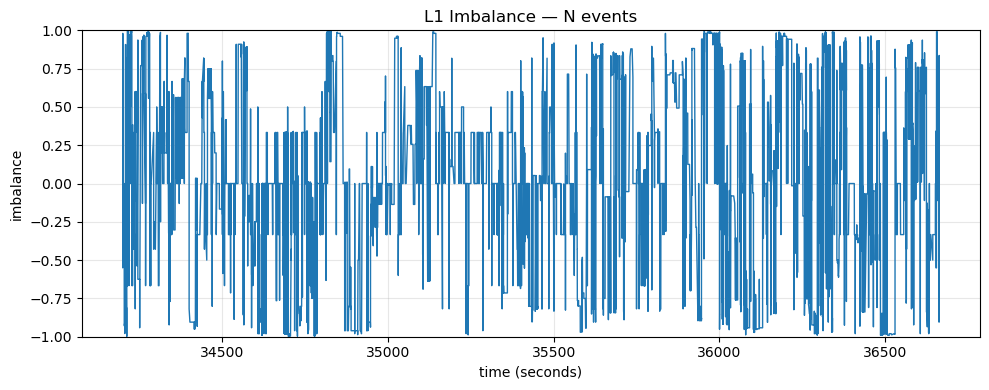

In [ ]:
N = 20000

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["imbalance_l1"].head(N).index, df["imbalance_l1"].head(N).values, linewidth=1)

ax.set_title("L1 Imbalance — N events")
ax.set_xlabel("time (seconds)")
ax.set_ylabel("imbalance")
ax.set_ylim(-1, 1)
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()


